# 2: Tumor Proliferation Analysis

Demonstrate the usage of SpatialCells to analyse tumor cell proliferation, especially using a multivariate proliferation index (MPI) adapted from Gaglia et al. 2022
https://doi.org/10.1038/s41556-022-00860-9

@author: Guihong Wan and Boshen Yan      
@date: Sept 28, 2023        
@last updated: Oct 6, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

import spatialcells as spc

## Load data

In [2]:
adata = ad.read_h5ad("../../data/MEL1_adata.h5ad")
spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug=True)
spc.prep.setGate(adata, "KERATIN_cellRingMask", 6.4, debug=True)

SOX10_cellRingMask_positive
False    566576
True     544009
Name: count, dtype: int64
KERATIN_cellRingMask_positive
False    1067400
True       43185
Name: count, dtype: int64


## Sliding window Analyses

We conduct a sliding window composition analysis to understand the spatial distribution of proliferating tumor cells.

### Compute MPI

In [3]:
help(spc.msmt.getMPI)

Help on function getMPI in module spatialcells.measurements._getMPI:

getMPI(adata, prolif_markers, arrest_markers, thresh_prolif=0.5, thresh_arrest=0.5, use_obs=False, use_layer=None, col_name='MPI', inplace=True)
    Get MPI from a list of markers and thresholds, adapted from Gaglia et al. 2022
    https://doi.org/10.1038/s41556-022-00860-9. The MPI is defined as follows:
    -1 if max(arrest_markers) > thresh_arrest
    1 else if max(prolif_markers) > thresh_prolif
    0 otherwise
    
    :param adata: AnnData object
    :param prolif_marker: List of proliferation markers
    :param arrest_markers: List of arrest markers
    :param thresh_prolif: Threshold for proliferation. Default is 0.5
    :param thresh_arrest: Threshold for arrest, which should be set
        based on the expression levels of KI67 marker. Default is 0.5
    :param use_obs: If True, use adata.obs[use_obs] to get the markers.
        Overrides use_layer. If use_obs==False and use_layer is None, use adata.X
    :

In [4]:
spc.msmt.getMPI(
    adata,
    prolif_markers=["KI67_cellRingMask"],
    arrest_markers=[],
    thresh_prolif=7.2,
    thresh_arrest=0.5,
    use_layer=None,
    col_name="MPI_KI67",
    inplace=True,
)

adata.obs["MPI_KI67"].value_counts()

No arrest markers found. Skipping.


MPI_KI67
0.0    1055001
1.0      55584
Name: count, dtype: int64

In [5]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 1110585 × 6
    obs: 'X_centroid', 'Y_centroid', 'SOX10_cellRingMask_positive', 'KERATIN_cellRingMask_positive', 'MPI_KI67'
    uns: 'all_markers'>

After calculating MPI, we draw an extended region boundary of the tumor region for the sliding window.

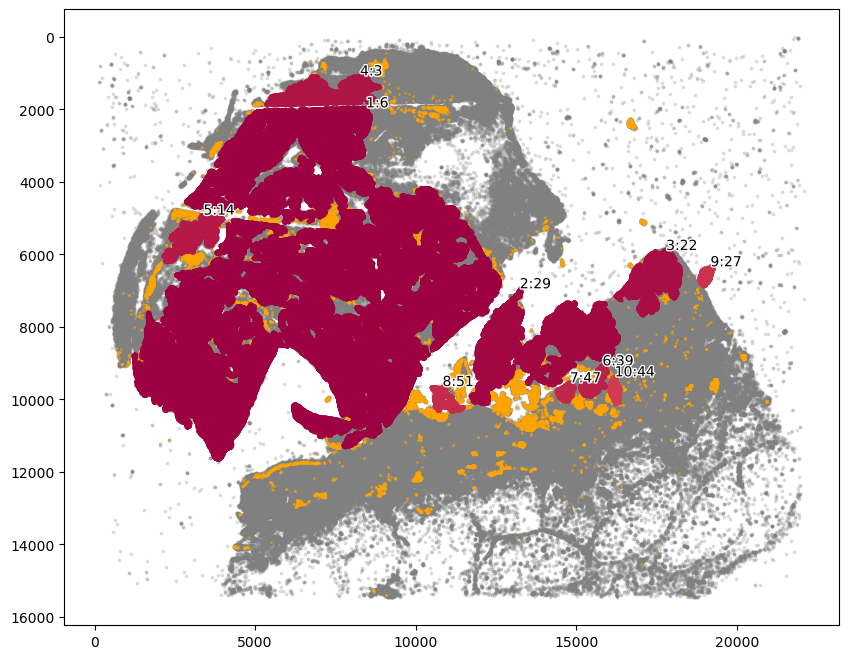

In [6]:
marker = ["SOX10_cellRingMask_positive"]
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, marker, eps=60, newcolumn=communitycolumn)

fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=2, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

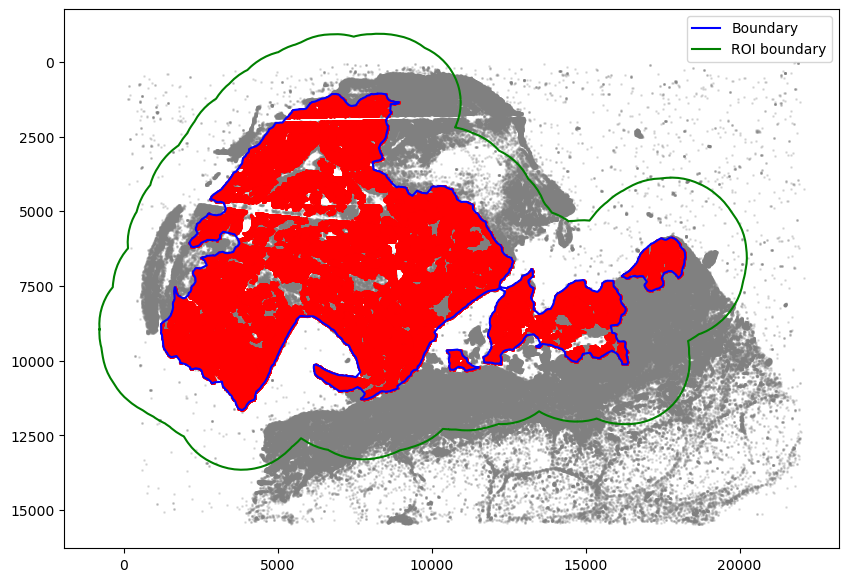

In [7]:
communityIndexList = [6, 3, 14, 51, 29, 47, 39, 44, 22]
boundary = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=130
)
boundary = spc.spa.pruneSmallComponents(boundary, min_edges=50, holes_min_edges=500)
roi_boundary = spc.spa.getExtendedBoundary(boundary, offset=2000)

markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
# Bounds of points in selected commnities
spc.plt.plotBoundary(boundary, ax=ax, label="Boundary", color="b")
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")

ax.invert_yaxis()
plt.legend(loc="upper right")
plt.show()

### Assign cells to the region

1094867it [00:53, 20572.10it/s]


Assigned points to region: ROI


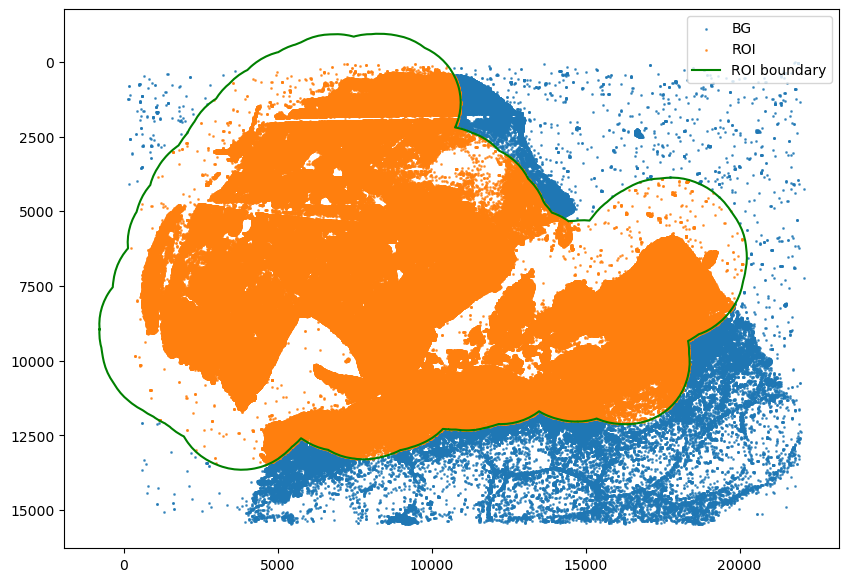

In [8]:
spc.spatial.assignPointsToRegions(
    adata, [roi_boundary], ["ROI"], assigncolumn="region", default="BG"
)

point_size = 1
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.7,
        label=region
    )
# Bounds of points in selected commnities
spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")

plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

In [9]:
spc.msmt.getRegionComposition(
    adata, ["SOX10_cellRingMask_positive", "MPI_KI67"], regions="ROI"
)

,SOX10_cellRingMask_positive,MPI_KI67,cell_count,composition
0,True,0.0,516886,0.951852
1,False,0.0,455092,0.940350
2,False,1.0,28868,0.059650
3,True,1.0,26146,0.048148


In [10]:
# only tumor cells
adata1 = adata[adata.obs["SOX10_cellRingMask_positive"]]
print(adata1.obs.shape)

size = 300
prolif_df_ki67 = spc.msmt.getSlidingWindowsComposition(
    adata1,
    size,
    size,
    "MPI_KI67",
    region_subset=["ROI"],
    min_cells=50,
)

prolif_df_ki67.head()

(544009, 7)


,MPI_KI67,cell_count,composition,X_start,Y_start,window_size,step_size
0,0.0,65,0.866667,966,8849,300,300
1,1.0,10,0.133333,966,8849,300,300
0,0.0,53,1.000000,1266,8249,300,300
0,0.0,260,0.996169,1266,8549,300,300
1,1.0,1,0.003831,1266,8549,300,300


In [11]:
def threshold_my_cmap(cmap, threshold, val=0):
    from matplotlib.colors import ListedColormap
    import matplotlib

    colormap = matplotlib.colormaps[cmap]
    newcolors = colormap(np.linspace(0, 1, 256))
    color = np.array([val, val, val, 1])
    newcolors[:threshold, :] = color
    newcmp = ListedColormap(newcolors)
    return newcmp


myGreens = threshold_my_cmap("Greens", 2, 1)
myReds = threshold_my_cmap("Reds", 2, 1)

mask = spc.msmt.get_comp_mask(prolif_df_ki67, "MPI_KI67", [1.0], size)

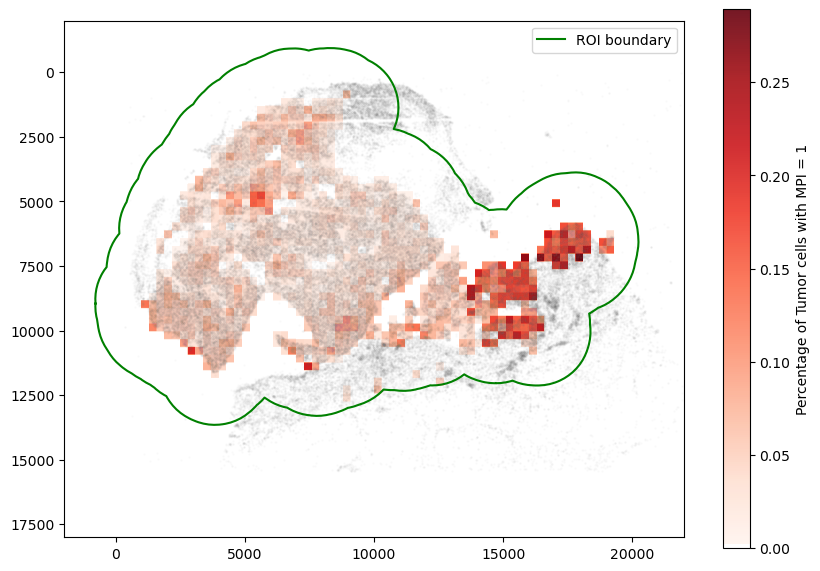

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.imshow(mask, alpha=0.9, cmap=myReds, extent=(0, 1, 0, 1))
cbar = plt.colorbar()
cbar.ax.set_ylabel("Percentage of Tumor cells with MPI = 1")
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region].sample(frac=0.1)
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=1,
        alpha=0.02,
        color="grey"
    )

spc.plt.plotBoundary(roi_boundary, ax=ax, label="ROI boundary", color="g")
ax.imshow(mask, alpha=1, cmap=myReds)
plt.legend(loc="upper right", markerscale=10)
ax.invert_yaxis()
ax.set_ylim(18000, -2000)
ax.set_xlim(-2000, 22000)
# plt.savefig("MPI_KI67_ROI.png", dpi=300)
plt.show()

<Axes: xlabel='MPI_KI67', ylabel='composition'>

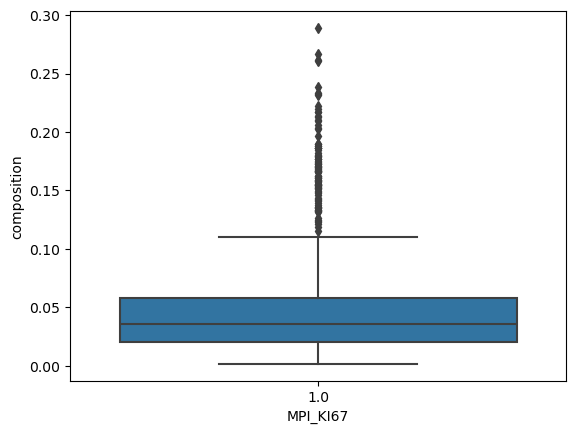

In [13]:
sns.boxplot(
    data=prolif_df_ki67[prolif_df_ki67["MPI_KI67"] == 1],
    x="MPI_KI67",
    y="composition",
)

We can also look at the distance of each window from the epidermis to capture if the tumor is undergoing horizontal or vertical growth.

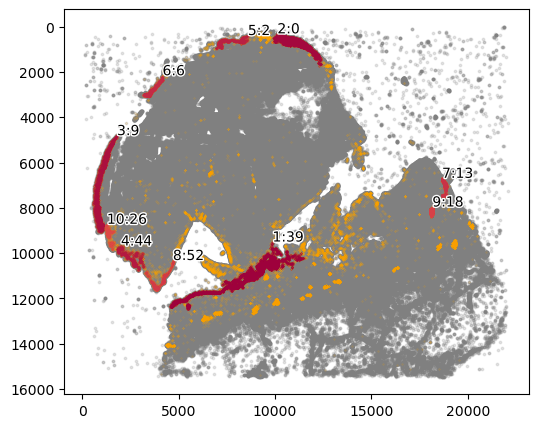

In [14]:
# adata.obs["keratinocytes"] = adata.obs["phenotype_large_cohort"].isin(["Keratinocytes"])
marker = ["KERATIN_cellRingMask_positive"]
communitycolumn = "epi_community"
ret = spc.spatial.getCommunities(adata, marker, eps=100, newcolumn=communitycolumn)

plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(6, 5))
spc.plt.plotCommunities(
    adata,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=0.1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

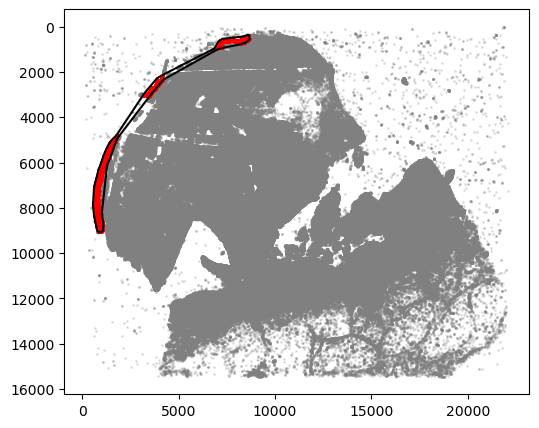

In [15]:
communityIndexList = [2, 6, 9]
epi_boundary = spc.spa.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=3000
)

markersize = 1
fig, ax = plt.subplots(figsize=(6, 5))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
spc.plt.plotBoundary(epi_boundary, ax=ax, linewidth=1.5, color="k")
ax.invert_yaxis()
plt.show()

In [16]:
prolif_df_ki67["x"] = prolif_df_ki67["X_start"] + prolif_df_ki67["window_size"] / 2
prolif_df_ki67["y"] = prolif_df_ki67["Y_start"] + prolif_df_ki67["window_size"] / 2
prolif_adata = ad.AnnData(obs=prolif_df_ki67)

spc.msmt.getDistanceFromObject(
    prolif_adata, 
    epi_boundary, 
    x="x", 
    y="y", 
    region_col="MPI_KI67", 
    region_subset=[1.0]
)

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
0it [00:00, ?it/s]

987it [00:00, 33236.81it/s]


In [17]:
prolif_adata.obs

,MPI_KI67,cell_count,composition,X_start,Y_start,window_size,step_size,x,y,distance
0,0.0,65,0.866667,966,8849,300,300,1116.0,8999.0,NaN
1,1.0,10,0.133333,966,8849,300,300,1116.0,8999.0,53.498597
0,0.0,53,1.000000,1266,8249,300,300,1416.0,8399.0,NaN
0,0.0,260,0.996169,1266,8549,300,300,1416.0,8699.0,NaN
1,1.0,1,0.003831,1266,8549,300,300,1416.0,8699.0,321.845776
...,...,...,...,...,...,...,...,...,...,...
1,1.0,9,0.039474,18966,6149,300,300,19116.0,6299.0,11913.575943
0,0.0,720,0.892193,18966,6449,300,300,19116.0,6599.0,NaN
1,1.0,87,0.107807,18966,6449,300,300,19116.0,6599.0,12061.068139
0,0.0,82,0.845361,18966,6749,300,300,19116.0,6899.0,NaN


Text(0.5, 0, 'Distance to epidermis (um)')

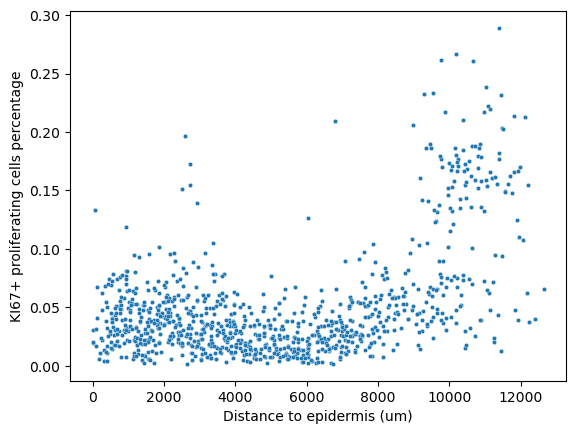

In [18]:
sns.scatterplot(
    data=prolif_adata.obs[prolif_adata.obs["MPI_KI67"] == 1.0],
    x="distance",
    y="composition",
    s=10,
)
plt.ylabel("KI67+ proliferating cells percentage")
plt.xlabel("Distance to epidermis (um)")